In [1]:
import numpy as np
import cv2
import os
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
default_image_size = tuple((256, 256))
resized_image_size = tuple((227,227))
image_size = 0
directory_root = 'E:\\Project\\'

In [4]:
# Function to convert image to array.
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, resized_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
# Reading the images from the dataset folder.
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:50]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed!")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing BANANA_DISEASE_LEAF STEAK ...
[INFO] Processing BANANA_HEALTHY ...
[INFO] Processing BLACK-PEPPER_DISEASED_ANTHRACNOSE ...
[INFO] Processing BLACK-PEPPER_HEALTHY ...
[INFO] Processing BRINJAL_DISEASED_LEAF BLIGHT ...
[INFO] Processing BRINJAL_DISEASED_LEAF CURL ...
[INFO] Processing BRINJAL_DISEASED_LEAF SPOT ...
[INFO] Processing BRINJAL_DISEASED_MOLD ...
[INFO] Processing BRINJAL_HEALTHY ...
[INFO] Processing CABBAGE_HEALTHY ...
[INFO] Processing CASSAVA_DISEASED_LEAF SPOT ...
[INFO] Processing CASSAVA_DISEASED_MOSAIC ...
[INFO] Processing CHILLI-PEPPER_CHLOROSIS ...
[INFO] Processing CHILLI-PEPPER_DISEASED_LEAF CURL ...
[INFO] Processing CHILLI-PEPPER_DISEASED_LEAF SPOT ...
[INFO] Processing CHILLI-PEPPER_DISEASED_MOSIAC ...
[INFO] Processing CHILLI-PEPPER_HEALTHY ...
[INFO] Processing CITRUS_DISEASED_MITE ...
[INFO] Processing CITRUS_DISEASED_MOLD ...
[INFO] Processing CITRUS_DISEASED_YELLOWING ...
[INFO] Processing CITRUS_HEALTH ...
[INF

In [6]:
# Assign the classes to images.
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [7]:
from collections import Counter
print(Counter(label_list).keys() )
print(Counter(label_list).values())

dict_keys(['BANANA_DISEASE_LEAF STEAK', 'BANANA_HEALTHY', 'BLACK-PEPPER_DISEASED_ANTHRACNOSE', 'BLACK-PEPPER_HEALTHY', 'BRINJAL_DISEASED_LEAF BLIGHT', 'BRINJAL_DISEASED_LEAF CURL', 'BRINJAL_DISEASED_LEAF SPOT', 'BRINJAL_DISEASED_MOLD', 'BRINJAL_HEALTHY', 'CABBAGE_HEALTHY', 'CASSAVA_DISEASED_LEAF SPOT', 'CASSAVA_DISEASED_MOSAIC', 'CHILLI-PEPPER_CHLOROSIS', 'CHILLI-PEPPER_DISEASED_LEAF CURL', 'CHILLI-PEPPER_DISEASED_LEAF SPOT', 'CHILLI-PEPPER_DISEASED_MOSIAC', 'CHILLI-PEPPER_HEALTHY', 'CITRUS_DISEASED_MITE', 'CITRUS_DISEASED_MOLD', 'CITRUS_DISEASED_YELLOWING', 'CITRUS_HEALTH', 'GUAVA_DISEASED_HEALTHY', 'GUAVA_DISEASED_LEAF SPOT', 'GUAVA_DISEASED_PEST', 'GUAVA_DISEASED_SOOTY MOLD', 'GUAVA_DISEASES_LEAF SPOT', 'OKRA_DISEASED_LEAF SPOT', 'OKRA_DISEASED_MOSAIC', 'OKRA_HEALTHY', 'PAPAYA_HEALTHY'])
dict_values([35, 33, 22, 44, 22, 18, 49, 12, 49, 49, 23, 49, 22, 49, 14, 33, 49, 49, 49, 49, 22, 32, 49, 49, 27, 36, 22, 49, 30, 17])


In [8]:
labels = len(label_binarizer.classes_)
print(labels)

30


In [9]:
# Convert the array to a NumPy list and normalise it.
np_image_list = np.array(image_list, dtype = np.float16) / 225.0
print("Total Images" , " : " ,len(np_image_list))
del image_list

Total Images  :  1052


In [10]:
print("[INFO] Spliting data into train set and test set ...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size = 0.5, random_state = 42) 
print("[INFO] Spliting complete!")
print("x_Train" ," : " , len(x_train))
print("y_Train" ," : " , len(y_train))
print("x_Test" ," : " , len(x_test))
print("y_Test" ," : " , len(y_test))
del np_image_list
del image_labels

[INFO] Spliting data into train set and test set ...
[INFO] Spliting complete!
x_Train  :  526
y_Train  :  526
x_Test  :  526
y_Test  :  526


In [11]:
aug = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True, 
    fill_mode = "nearest")

In [12]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import os, gc, sys, glob
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from keras.losses import MeanSquaredError
from keras.models import Sequential, load_model

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras import applications
from keras.callbacks import ReduceLROnPlateau

from keras.layers import LayerNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [13]:
img_rows, img_cols, img_channel = 227,227, 3

base_model =tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=(img_rows, img_cols, img_channel),
    pooling='avg',
)

print(base_model.summary())


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

 batch_normalization_5 (BatchNo  (None, 26, 26, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 26, 26, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 26, 26, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 26, 26, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 26, 26, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 26, 26, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 26, 26, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 26, 26, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 26, 26, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 26, 26, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 26, 26, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 26, 26, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 26, 26, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 26, 26, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 26, 26, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 26, 26, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 26, 26, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 26, 26, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 26, 26, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 26, 26, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 26, 26, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 26, 26, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 26, 26, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 26, 26, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 26, 26, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 26, 26, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 26, 26, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 26, 26, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 26, 26, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 26, 26, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 12, 12, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 12, 12, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 12, 12, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 12, 12, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 12, 12, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 12, 12, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 12, 12, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 12, 12, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 12, 12, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 12, 12, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 12, 12, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 12, 12, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 12, 12, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 12, 12, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 5, 5, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 5, 5, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 5, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 5, 5, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 alAveragePooling2D)                                                                              
                                                                                                  
Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________
None


In [14]:
outputs = tf.keras.layers.Dense(labels, activation='softmax')(base_model.output)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [15]:
EPOCHS = 100
INIT_LR = 1e-4
Decay = 1e-5

# compile the model
opt = opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

print("[INFO] Training network...")

# Train
checkpoint = ModelCheckpoint("OD_IRV2_OD.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'max')


history = model.fit(
    aug.flow(x_train, y_train, shuffle = False),
    validation_data = (x_test, y_test),
    validation_freq=1,
    batch_size = 32,
    callbacks = [checkpoint],
    epochs = EPOCHS,)

[INFO] Training network...
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 3.1248 - accuracy: 0.1711
Epoch 1: val_accuracy improved from -inf to 0.23954, saving model to OD_IRV2_OD.h5
17/17 [==============================] - 33s 773ms/step - loss: 3.1248 - accuracy: 0.1711 - val_loss: 2.8302 - val_accuracy: 0.2395
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 1.8311 - accuracy: 0.6046
Epoch 2: val_accuracy improved from 0.23954 to 0.44106, saving model to OD_IRV2_OD.h5
17/17 [==============================] - 15s 932ms/step - loss: 1.8311 - accuracy: 0.6046 - val_loss: 1.9955 - val_accuracy: 0.4411
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.9246 - accuracy: 0.7624
Epoch 3: val_accuracy improved from 0.44106 to 0.56654, saving model to OD_IRV2_OD.h5
17/17 [==============================] - 9s 525ms/step - loss: 0.9246 - accuracy: 0.7624 - val_loss: 1.5330 - val_accuracy: 0.5665
Epoch 4/100
17/17 [===================

Epoch 29/100
17/17 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9981
Epoch 29: val_accuracy did not improve from 0.77567
17/17 [==============================] - 8s 443ms/step - loss: 0.0154 - accuracy: 0.9981 - val_loss: 1.6603 - val_accuracy: 0.7376
Epoch 30/100
17/17 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9867
Epoch 30: val_accuracy did not improve from 0.77567
17/17 [==============================] - 8s 448ms/step - loss: 0.0317 - accuracy: 0.9867 - val_loss: 1.2401 - val_accuracy: 0.7643
Epoch 31/100
17/17 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9867
Epoch 31: val_accuracy did not improve from 0.77567
17/17 [==============================] - 8s 452ms/step - loss: 0.0473 - accuracy: 0.9867 - val_loss: 1.1622 - val_accuracy: 0.7643
Epoch 32/100
17/17 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9943
Epoch 32: val_accuracy did not improve from 0.77567
17/17 [========

Epoch 58/100
17/17 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 58: val_accuracy did not improve from 0.79658
17/17 [==============================] - 8s 449ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.1196 - val_accuracy: 0.7947
Epoch 59/100
17/17 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 59: val_accuracy did not improve from 0.79658
17/17 [==============================] - 8s 450ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1208 - val_accuracy: 0.7928
Epoch 60/100
17/17 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 0.79658
17/17 [==============================] - 8s 449ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1057 - val_accuracy: 0.7947
Epoch 61/100
17/17 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 61: val_accuracy did not improve from 0.79658
17/17 [========

Epoch 87/100
17/17 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000
Epoch 87: val_accuracy did not improve from 0.79848
17/17 [==============================] - 8s 456ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.3847 - val_accuracy: 0.7529
Epoch 88/100
17/17 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 88: val_accuracy did not improve from 0.79848
17/17 [==============================] - 8s 457ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.3902 - val_accuracy: 0.7605
Epoch 89/100
17/17 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9981
Epoch 89: val_accuracy did not improve from 0.79848
17/17 [==============================] - 8s 451ms/step - loss: 0.0043 - accuracy: 0.9981 - val_loss: 1.4914 - val_accuracy: 0.7452
Epoch 90/100
17/17 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9962
Epoch 90: val_accuracy did not improve from 0.79848
17/17 [========

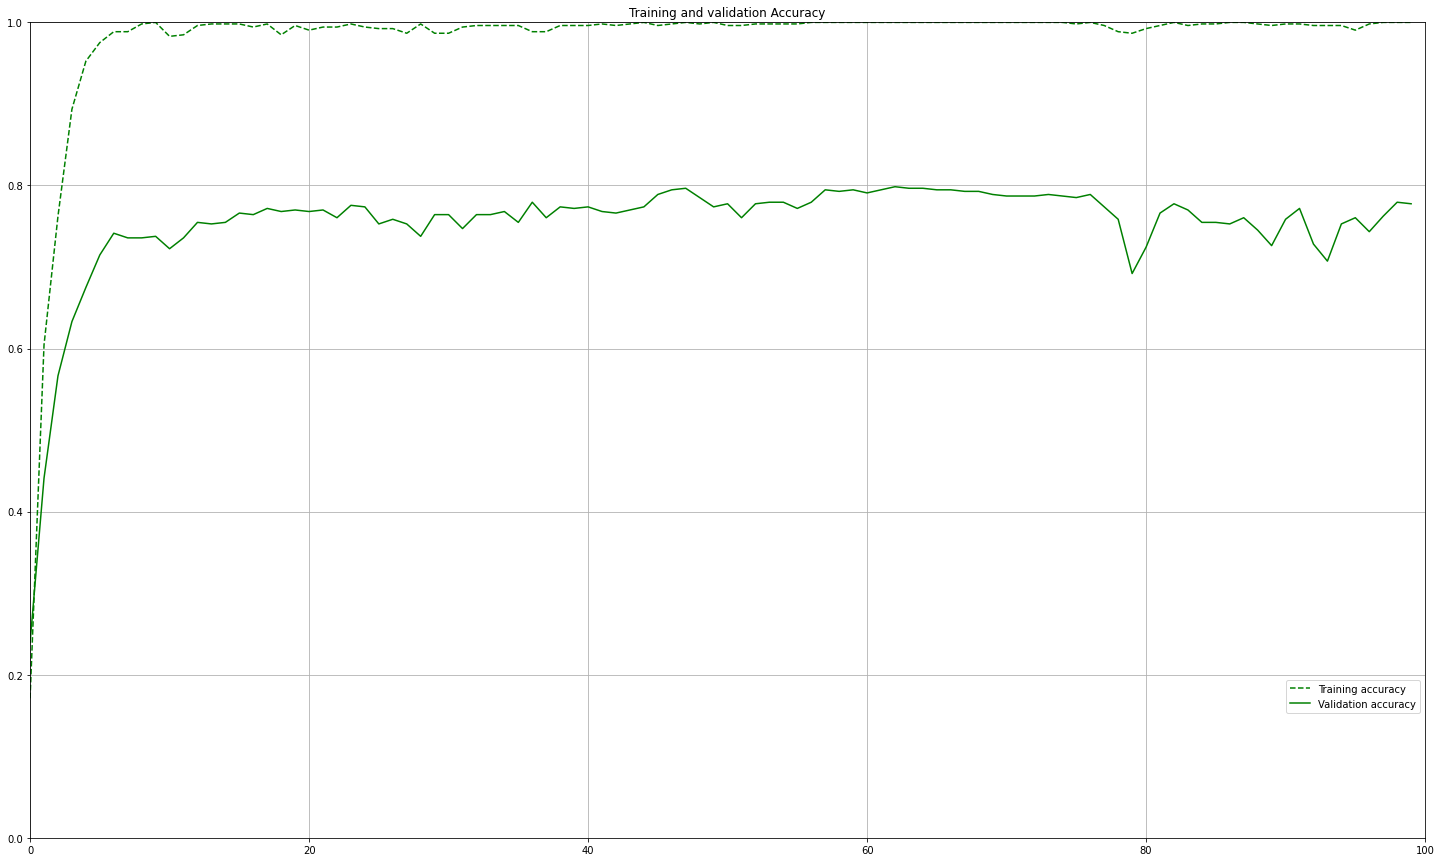

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(25, 15))
xmin = 0
xmax = 100
ymin = 0.0
ymax = 1.0
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
    
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, acc, 'g--', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation accuracy')
plt.title('Training and validation Accuracy')
plt.legend(bbox_to_anchor=(1, 0.2))

plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(25, 15))
    #Plot the Result
xmin = 0
xmax = 100
ymin = 0.0
ymax = 3.0

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
    
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, loss, 'r--', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and validation loss' , fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.2))

plt.grid()
plt.show()

In [ ]:
model = load_model("OD_IRV2_OD.h5")
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")